In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from scipy.stats import norm, kstest

# Oxford
`OX_1-1_pouch_LCO_40C_0-100_2-1.84C_a_timeseries`

| Cell ID                                | Anode    | Cathode | Source  | Ah   | Form Factor | Temperature (C) | Max SOC | Min SOC | Charge Rate (C) | Discharge Rate (C) |
|----------------------------------------|----------|---------|---------|------|-------------|-----------------|---------|---------|-----------------|--------------------|
| OX_1-1_pouch_LCO_40C_0-100_2-1.84C_a_timeseries | graphite | LCO     | oxford  | 0.74 | pouch       | 40.00           | 100.00  | 0.00    | 2.00            | 1.84               |

## Limpeza e preparação

- Corrente negativa --> descarga
- Corrente positiva --> carga

In [24]:
# Header completo:
# Date_Time,Test_Time (s),Cycle_Index,Current (A),Voltage (V),Charge_Capacity (Ah),Discharge_Capacity (Ah),Charge_Energy (Wh),Discharge_Energy (Wh),Environment_Temperature (C),Cell_Temperature (C)
df = pd.read_csv('../Battery_Archive_Data/HNEI/2.80_HNEI_18650_NMC_LCO_25C_0-100_0.5-1.5C_a_timeseries.csv')

# Apenas features de interesse são mantidas
# Obs: Envoironment_Temperature (C) poderia ser relevante, mas tem todos os valores nulos. Então, é removida
df = df[["Cycle_Index", "Test_Time (s)", "Current (A)", "Voltage (V)", "Discharge_Capacity (Ah)", "Cell_Temperature (C)"]]

# Mantem apenas as linhas em que a bateria está descarregando, ou seja, corrente < 0
df = df[df['Current (A)'] < 0]

# Remove valores para Cell_Temperature < 1 (incorretos)
#df = df[df['Cell_Temperature (C)'] >= 1]

display(df)
display(df.describe())

,Cycle_Index,Test_Time (s),Current (A),Voltage (V),Discharge_Capacity (Ah),Cell_Temperature (C)
2,1.0,6.729400e+01,-1.398,3.670,0.001,NaN
3,1.0,7.430300e+01,-1.398,3.664,0.004,NaN
4,1.0,8.131000e+01,-1.399,3.659,0.006,NaN
5,1.0,8.831900e+01,-1.398,3.656,0.009,NaN
6,1.0,9.529400e+01,-1.399,3.654,0.012,NaN
...,...,...,...,...,...,...
651026,1113.0,1.627613e+07,-0.052,3.794,0.989,NaN
651027,1113.0,1.627616e+07,-0.051,3.794,0.989,NaN
651028,1113.0,1.627619e+07,-0.052,3.794,0.990,NaN
651029,1113.0,1.627622e+07,-0.051,3.794,0.990,NaN


,Cycle_Index,Test_Time (s),Current (A),Voltage (V),Discharge_Capacity (Ah),Cell_Temperature (C)
count,251438.000000,2.514380e+05,251438.000000,251438.000000,251438.000000,0.0
mean,409.843102,6.645530e+06,-3.373954,3.532332,1.073525,NaN
std,349.620161,4.753022e+06,1.576148,0.262884,0.687229,NaN
min,1.000000,6.729400e+01,-4.199000,2.799000,0.000000,NaN
25%,64.000000,1.826308e+06,-4.198000,3.345000,0.496000,NaN
50%,328.000000,5.939024e+06,-4.198000,3.509000,1.000000,NaN
75%,695.000000,1.054520e+07,-4.197000,3.728000,1.592000,NaN
max,1113.000000,1.627624e+07,-0.049000,4.290000,2.931000,NaN


## Visualização

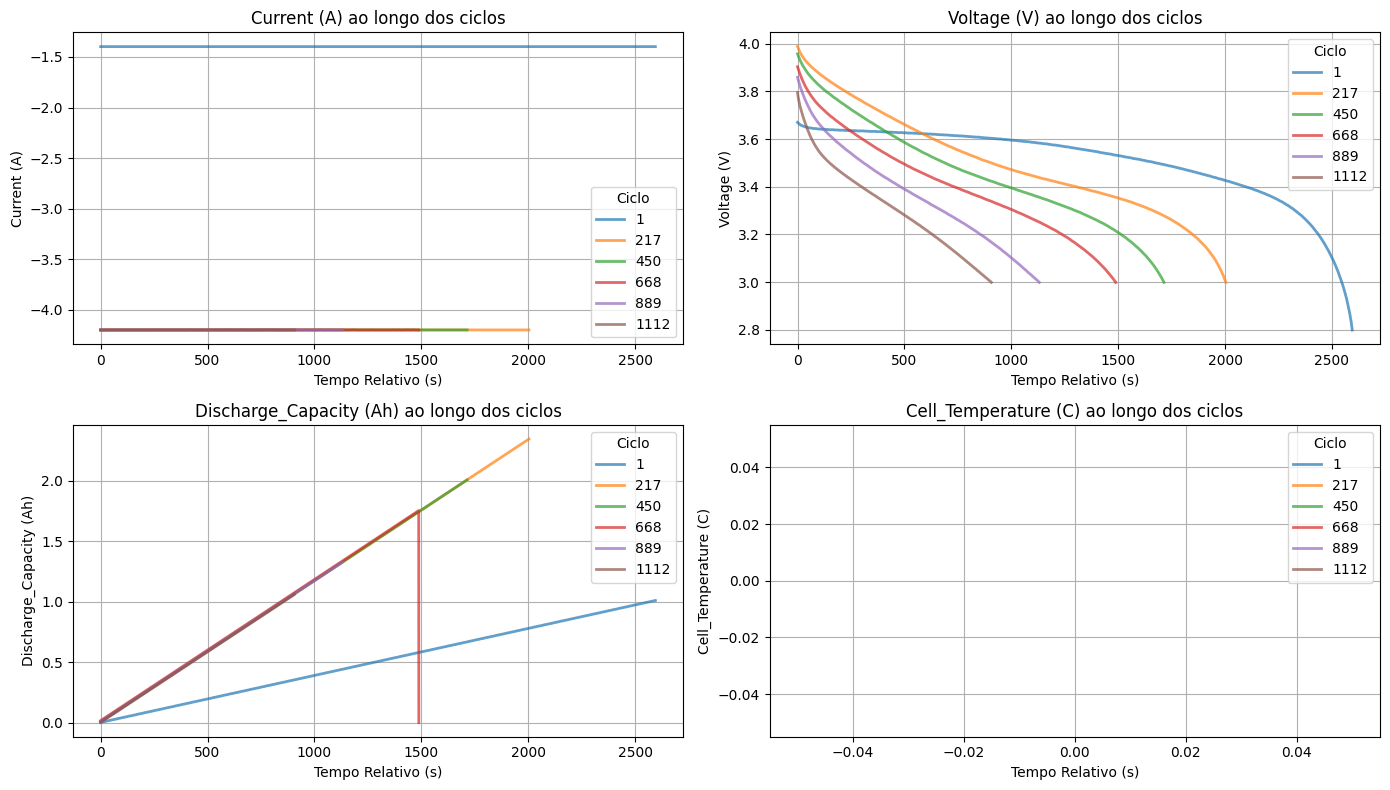

In [25]:
# Lista de features que deseja analisar (exceto "Cycle_Index")
features = ["Current (A)", "Voltage (V)", "Discharge_Capacity (Ah)", "Cell_Temperature (C)"]

# Ciclos únicos e ordenados
cycles = df["Cycle_Index"].unique()
cycles.sort()
NumCyclesPlot = 5

# Seleciona 'NumCyclesPlot' ciclos igualmente espaçados para plotar
if len(cycles) > NumCyclesPlot:
    cycles = cycles[::len(cycles)//NumCyclesPlot] # // --> Divisão inteira

# Cria os subplots com layout 2x2
fig, axs = plt.subplots(2, 2, figsize=(14, 8))
axs = axs.flatten()  # Facilita a iteração

# Itera sobre cada feature e sobre os ciclos para plotar os dados
for i, feature in enumerate(features):
    ax = axs[i]
    for cycle in cycles:
        # Seleciona os dados do ciclo e calcula o tempo relativo
        df_cycle = df[df["Cycle_Index"] == cycle].copy()
        df_cycle['Tempo_Relativo (s)'] = df_cycle["Test_Time (s)"] - df_cycle["Test_Time (s)"].min()
        
        # Plota a feature em função do tempo relativo
        ax.plot(df_cycle['Tempo_Relativo (s)'], df_cycle[feature], alpha=0.7, label=f'{int(cycle)}', linewidth=2.0)

    ax.set_title(f'{feature} ao longo dos ciclos')
    ax.set_xlabel('Tempo Relativo (s)')
    ax.set_ylabel(feature)
    ax.grid(True)
    ax.legend(title="Ciclo", loc='best')

plt.tight_layout()
plt.show()


## Análise de SOH

$$
\text{SOH} = \frac{\text{capacidade\_atual}}{\text{capacidade\_inicial}}
$$

- $CapacidadeInicial$ é a capacidade nominal, a maior considerando todo o histórico da bateria
- $CapacidadeAtual$ é a maior capacidade do ciclo

In [26]:
# Capacidade nominal (máxima global)
nominal_capacity = df['Discharge_Capacity (Ah)'].max()
print(f'Capacidade total de descarga: {nominal_capacity} Ah')

# Para cada ciclo, extrai a maior capacidade 
# (cycles_capacity é uma série do Pandas)
cycles_capacity = df.groupby('Cycle_Index')['Discharge_Capacity (Ah)'].max()
cycles_capacity = cycles_capacity.reset_index() # transforma em dataframe
cycles_capacity.columns = ['Cycle_Index', 'Max_Discharge_Capacity']
cycles_capacity['SOH_discharge'] = (cycles_capacity['Max_Discharge_Capacity'] / nominal_capacity)
display(cycles_capacity)

Capacidade total de descarga: 2.931 Ah


,Cycle_Index,Max_Discharge_Capacity,SOH_discharge
0,1.0,1.009,0.344251
1,2.0,2.878,0.981917
2,3.0,2.872,0.979870
3,4.0,2.869,0.978847
4,5.0,2.865,0.977482
...,...,...,...
1077,1109.0,1.089,0.371546
1078,1110.0,1.086,0.370522
1079,1111.0,1.080,0.368475
1080,1112.0,1.059,0.361310


In [27]:
# Seleciona as features de interesse e agrupa por ciclo
df_grouped = df[['Cycle_Index', 'Cell_Temperature (C)']]
df_grouped = df_grouped.groupby('Cycle_Index', as_index=False).mean() # Média será usada para a temperatura

# Adição do SOH calculado em ciclos_capacity
df_grouped['SOH_discharge'] = cycles_capacity['SOH_discharge']

display(df_grouped)
display(df_grouped.describe())

,Cycle_Index,Cell_Temperature (C),SOH_discharge
0,1.0,NaN,0.344251
1,2.0,NaN,0.981917
2,3.0,NaN,0.979870
3,4.0,NaN,0.978847
4,5.0,NaN,0.977482
...,...,...,...
1077,1109.0,NaN,0.371546
1078,1110.0,NaN,0.370522
1079,1111.0,NaN,0.368475
1080,1112.0,NaN,0.361310


,Cycle_Index,Cell_Temperature (C),SOH_discharge
count,1082.000000,0.0,1082.000000
mean,556.469501,NaN,0.630781
std,323.696269,NaN,0.160987
min,1.000000,NaN,0.069260
25%,271.250000,NaN,0.474411
50%,559.500000,NaN,0.643296
75%,835.750000,NaN,0.769191
max,1113.000000,NaN,1.000000


### [numpy.interp() parameters](https://numpy.org/doc/2.1/reference/generated/numpy.interp.html):
- `x`: _array_like_ . The x-coordinates at which to evaluate the interpolated values.

- `xp`: _1-D sequence of floats_. The x-coordinates of the data points, must be increasing if argument period is not specified. Otherwise, xp is internally sorted after normalizing the periodic boundaries with xp = xp % period.

- `fp`: _1-D sequence of float or complex_. The y-coordinates of the data points, same length as xp.

Returns the one-dimensional piecewise linear interpolant to a function with given discrete data points (xp, fp), evaluated at x:
- `y`: float or complex (corresponding to fp) or ndarray. The interpolated values, same shape as x.

In [28]:
# Define thresholds de interesse (99%, 98%, ...)
thresholds = np.arange(1.00, 0.00, -0.01)

soh    = df_grouped['SOH_discharge'].values
cycles = df_grouped['Cycle_Index'].values

# inverte para que fique crescente
xp = soh[::-1]
fp = cycles[::-1]

valid = (thresholds >= xp.min()) & (thresholds <= xp.max())
thresholds = thresholds[valid]

# np.interp(x, xp, fp) assume xp crescente e retorna y para cada x em thresholds
estimated_cycles = np.interp(thresholds, xp, fp)

df_estimates = pd.DataFrame({
    'SOH_threshold':   thresholds,
    'estimated_cycle': estimated_cycles
})

# Cast
df_estimates['SOH_threshold']   = df_estimates['SOH_threshold'].astype(float).round(2)

# Number of cycles drop (1%)
df_estimates['NCD1%'] = df_estimates['estimated_cycle'].diff()

display(df_estimates)


,SOH_threshold,estimated_cycle,NCD1%
0,1.00,1.0,NaN
1,0.99,1.0,0.0
2,0.98,1.0,0.0
3,0.97,1.0,0.0
4,0.96,1.0,0.0
...,...,...,...
89,0.11,1113.0,0.0
90,0.10,1113.0,0.0
91,0.09,1113.0,0.0
92,0.08,1113.0,0.0


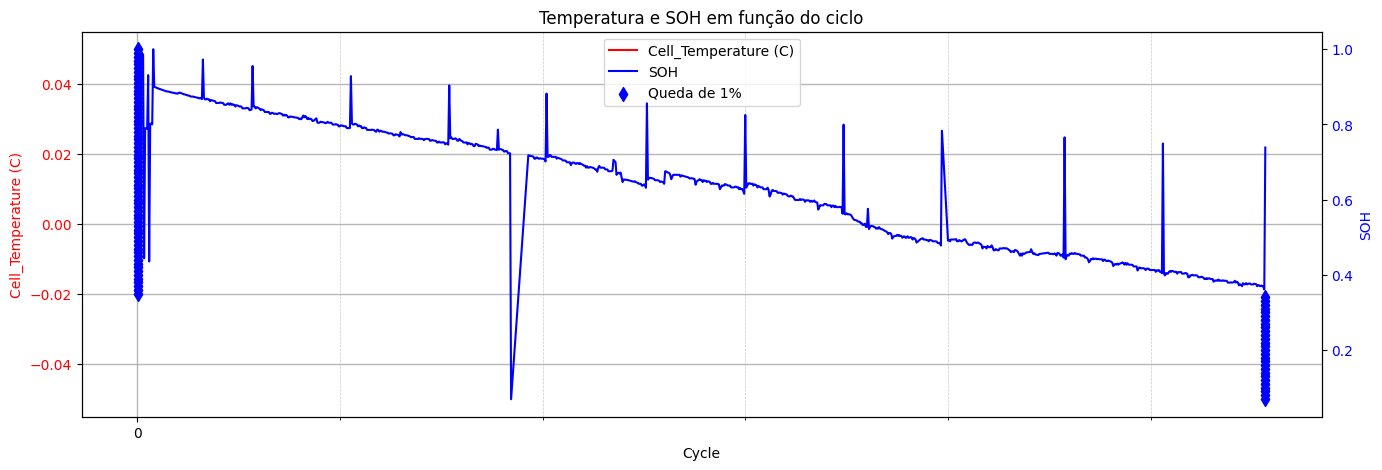

In [29]:
fig, ax1 = plt.subplots(figsize=(16,5))

# Eixo temperatura
ax1.plot(df_grouped["Cycle_Index"], df_grouped["Cell_Temperature (C)"], label="Cell_Temperature (C)", color='red')
ax1.set_xlabel("Cycle")
ax1.set_ylabel("Cell_Temperature (C)", color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Major ticks: 1, 2000, 4000, ...
xmin = df_grouped["Cycle_Index"].min()
xmax = df_grouped["Cycle_Index"].max()
major_ticks = np.arange(0, xmax+1, 2000)
ax1.set_xticks(major_ticks)

# Minor ticks: a cada 200 unidades
minor_ticks = np.arange(0, xmax+1, 200)
ax1.set_xticks(minor_ticks, minor=True)

# Grids
ax1.grid(which='major', linestyle='-', linewidth=1, alpha=0.9)
ax1.grid(which='minor', linestyle='--', linewidth=0.5, alpha=0.7)

# Eixo SOH
ax2 = ax1.twinx()
ax2.plot(df_grouped["Cycle_Index"], df_grouped["SOH_discharge"], label="SOH", color='blue')
ax2.set_ylabel("SOH", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

ax2.scatter(df_estimates["estimated_cycle"], df_estimates["SOH_threshold"], color='blue', marker='d', s=50, label="Queda de 1%")

plt.title("Temperatura e SOH em função do ciclo")

# Combina as legendas dos dois eixos
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper center')

plt.show()


Número de NCD1%: 93
Média: 11.96, Desvio-padrão: 115.31


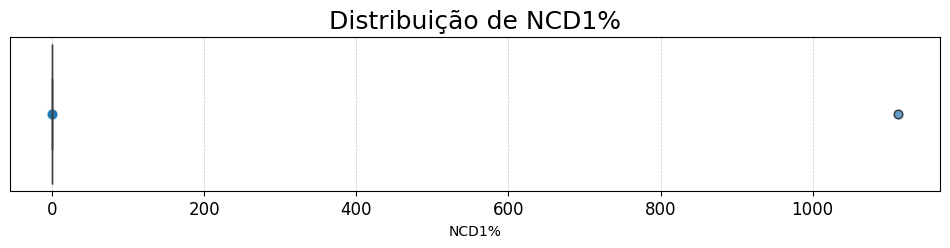

In [30]:
data = df_estimates["NCD1%"].dropna().values
print(f'Número de NCD1%: {len(data)}')

mean = np.mean(data)
std  = np.std(data, ddof=1)
print(f'Média: {mean:.2f}, Desvio-padrão: {std:.2f}')

# Seleciona a cor padrão 'C0' do matplotlib (primeira cor)
default_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
fig, ax = plt.subplots(figsize=(12, 2))

sns.boxplot(
    x=data,                   # valores no eixo x
    y=np.zeros_like(data),    # posição 0 no eixo y
    ax=ax,
    orient='h',
    linewidth=1,
    zorder=2
)

# Deixa a face do boxplot semitransparente
for patch in ax.patches:
    if hasattr(patch, 'get_facecolor'):
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, 0.3))  # alpha = 0.3

# Sobreposição de pontos (scatter) com baixa opacidade
sns.scatterplot(
    x=data,
    y=np.zeros_like(data),
    ax=ax,
    s=60,                     # tamanho dos pontos
    color=default_color,      # mesma cor do boxplot
    alpha=0.7,
    zorder=1
)

# Remove os ticks do eixo y (não fazem sentido aqui)
ax.set_yticks([])

ax.set_xlabel("NCD1%")
ax.tick_params(which='major', labelsize=12)

plt.title("Distribuição de NCD1%", fontsize=18)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

plt.show()

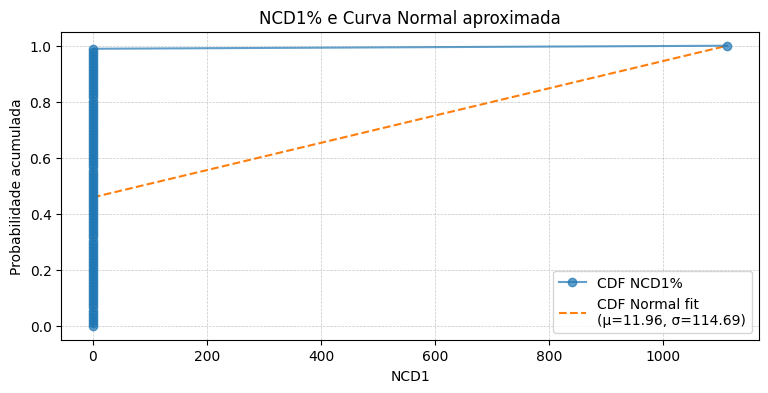

In [31]:
data = np.sort(data)  # Garante que os dados estão ordenados
n    = len(data)

# Faz o fitting para encotnrar os parametros e calcula a funcao acumulada dos dados considerando comportamento normal
mean, std = norm.fit(data)
teo_norm  = norm.cdf(data, loc=mean, scale=std)

plt.figure(figsize=(9, 4))

# Probabilidade acumulada empírica (1/n, 2/n, ..., 1)
cdf_emp = np.arange(0, n)/(n-1)
plt.plot(data, cdf_emp, marker='o', linestyle='-', label="CDF NCD1%", zorder=3, alpha=0.7)

# Função acumulada da normal (teórica)
plt.plot(data, teo_norm, linestyle='--', label=f"CDF Normal fit\n(μ={mean:.2f}, σ={std:.2f})")

plt.xlabel("NCD1")
plt.ylabel("Probabilidade acumulada")
plt.title("NCD1% e Curva Normal aproximada")
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

plt.show()


Teste de Kolmogorov–Smirnov (KS) para verificar formalmente se o conjunto de dados de NCD1% (`data`) segue a distribuição Normal com os parametros encontrados no método de fitting

De acordo com a [documentação de **kstest**](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html):
- ``rvs=data``
    - Array de observações ordenadas
- ``cdf='norm'`` 
    - Especifica que a distribuição teórica é a de uma normal
- ``args=(mean, std)`` 
    - Parâmetros (μ, σ) da normal teórica

Retorna:

- ``D (statistic) `` 
    - Representa a maior diferença absoluta entre aa curva dados e a CDF da Normal teórica
    - Quanto menor, mais próximo o ajuste está dos dados observados

- ``p-value``
    - Probabilidade de observar uma estatística \( D \) igual ou mais extrema sob a suposição de que os dados vêm de uma Normal
    - **Valores altos (> alpha) indicam falha em rejeitar a hipótese de normalidade**. 
    - Valores baixos (< alpha) indicam evidência contra a hipótese

In [32]:
statistic, p_value = kstest(rvs=data, cdf='norm', args=(mean, std))

print(f"KS statistic: {statistic:.4f}")
print(f"p-value: {p_value:.4f}")

alpha = 0.05 # não tenho certeza em qual valor usar aqui, mas 0.05 pareceu ser comum
print(f'alpha = {alpha}')
if p_value < alpha: print(f"Hipótese rejeitada.")
else: print(f"Hipótese aceita.")

KS statistic: 0.5308
p-value: 0.0000
alpha = 0.05
Hipótese rejeitada.
